In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets ,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline




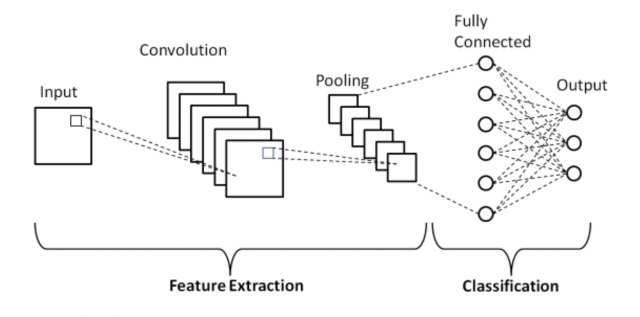

In [2]:
# Convert MNIST image files into a tensor of 4-Dimensions (#images, height, width, color channel)
transform =transforms.ToTensor()


In [3]:
#TRain data
train_data = datasets.MNIST(root='~/cnn_data', train=True, download=True, transform=transform)

In [4]:
#Test data
test_data = datasets.MNIST(root='~/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/aldo/cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/aldo/cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images = 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In PyTorch, the `Conv2d` layer represents a 2D convolutional layer, commonly used in convolutional neural networks (CNNs) for image processing tasks. The parameters for `nn.Conv2d(in_channels, out_channels, kernel_size, stride)` define the behavior of this layer. Here’s a breakdown for `conv1 = nn.Conv2d(1, 6, 3, 1)`:



---


1. **`in_channels=1`**: This specifies the number of input channels for the convolution. In this case, it's set to `1`, meaning the input has one channel (like a grayscale image). If it were an RGB image, you would set this to `3`.

2. **`out_channels=6`**: This specifies the number of output channels (also known as filters) the convolution will produce. Here, it's set to `6`, which means the layer will produce six different feature maps after applying the convolution.

3. **`kernel_size=3`**: This parameter determines the size of the convolutional kernel (filter). In this case, `3` means it will use a `3x3` kernel to scan across the image. This kernel size determines the receptive field over the input.

4. **`stride=1`**: This parameter sets the step size the kernel will take as it moves across the image. A stride of `1` means the kernel moves one pixel at a time. A higher stride reduces the spatial dimensions of the output.

This convolutional layer will transform the input image with one channel into an output with six channels, applying six separate `3x3` filters across the image with a stride of 1.

In [8]:
#Define or CNN Model
#Describe convolutional layer (2 cnn)
conv1 =nn.Conv2d(1,6,3,1)
conv2 =nn.Conv2d(6,16,3,1)

In [9]:
# Grab 1 MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28,28)

In [12]:
#Perform our first convolution
x = F.relu(conv1(x)) #Rectified Linear unit

In [13]:
x.shape
#The reason why it's now 26x26 is because it automatically sets a padding and removes 2 pixels from each side if we do not specify this number,
# in this case it does not matter
# but in later projects we whould be careful with this since we may lose data

torch.Size([1, 6, 26, 26])

In [14]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2,2) #kernel of 2 and stride of  2

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
# Second CL
x =F.relu(conv2(x))


In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
#pooling layer
x = F.max_pool2d(x,2,2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
#MODEL CLASS
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)#2X2 KERNEL AND STRIDE 2
    # SECOND PASS
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)#2X2 KERNEL AND STRIDE 2
    
    # REVIEW TO FLATTEN IT OUT
    X = X.view(-1,16*5*5) # -1 so that we can vary batch size
    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)



In [21]:
# Create instance of model
torch.manual_seed(41)
model = CNN()
model


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Smaller learning rate it's going to take to train longer to train


In [23]:
import time 
start_time = time.time()


# Create variables to track things
epochs= 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for e in range(epochs):
    trn_corr=0
    tst_corr=0
    
 
    #Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1 #startt batches at 1
        y_pred = model(X_train) #get predicted values from training set. Not flatten it's 2D
        loss=criterion(y_pred,y_train) # how off we are. Compare the predictions to the correct answers
        predicted = torch.max(y_pred.data,1)[1] # Add up number of correct predictions indexed from1
        batch_corr = (predicted ==y_train).sum() #how many we got correct from this batch
        trn_corr+= batch_corr # keep track as we go along training
      
        #Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #Print out results
        if b%600==0:
            print(f"Epoch: {e} Batch: {b} Loss: {loss.item()} Train Accuracy: {trn_corr/600}")
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    #Test
    with torch.no_grad(): #NO gradient so we dont update model parameters with test data
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1] #ADDING UP CORRECT PREDICTIONS
            tst_corr += (predicted==y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
  
    



current_time=time.time()
total = current_time-start_time
print(f"Training took : {total/60} minutes")

Epoch: 0 Batch: 600 Loss: 0.15999361872673035 Train Accuracy: 7.401666641235352
Epoch: 0 Batch: 1200 Loss: 0.18979428708553314 Train Accuracy: 16.59666633605957
Epoch: 0 Batch: 1800 Loss: 0.5580862164497375 Train Accuracy: 26.078332901000977
Epoch: 0 Batch: 2400 Loss: 0.2070169746875763 Train Accuracy: 35.630001068115234
Epoch: 0 Batch: 3000 Loss: 0.006888723466545343 Train Accuracy: 45.22999954223633
Epoch: 0 Batch: 3600 Loss: 0.3311269283294678 Train Accuracy: 54.88666534423828
Epoch: 0 Batch: 4200 Loss: 0.004664993844926357 Train Accuracy: 64.54833221435547
Epoch: 0 Batch: 4800 Loss: 0.002031726064160466 Train Accuracy: 74.29666900634766
Epoch: 0 Batch: 5400 Loss: 0.06567355245351791 Train Accuracy: 84.04166412353516
Epoch: 0 Batch: 6000 Loss: 0.0007259048288688064 Train Accuracy: 93.76333618164062
Epoch: 1 Batch: 600 Loss: 0.004907811991870403 Train Accuracy: 9.743332862854004
Epoch: 1 Batch: 1200 Loss: 0.3916364014148712 Train Accuracy: 19.559999465942383
Epoch: 1 Batch: 1800 Loss

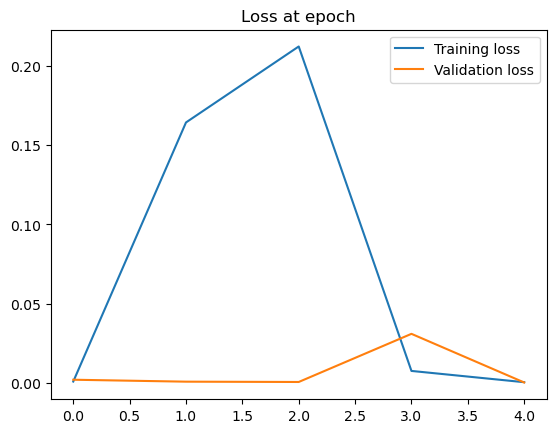

In [24]:
# graph loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses,label="Validation loss")
plt.title("Loss at epoch")
plt.legend()
plt.show()


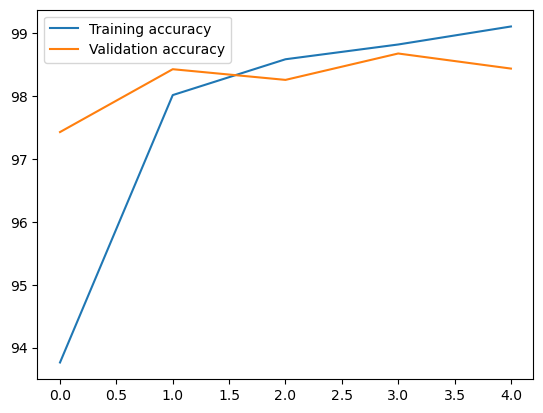

In [28]:
# accuracy
plt.plot([t/600 for t in train_correct], label='Training accuracy')
plt.plot([t/100 for t in test_correct], label='Validation accuracy')
plt.legend()
plt.show()

In [29]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [30]:
with torch.no_grad():
    correct =0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == y_test).sum()

In [33]:
correct.item()/len(test_data)*100

98.44000000000001

In [34]:
# Grab an image
test_data[4143] # tensor with an image in it...at the end, it shows the class label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [36]:
#grab just data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [42]:
# reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

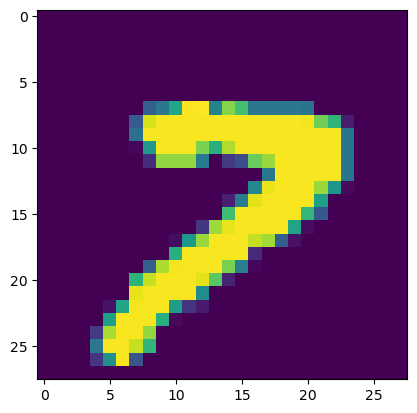

In [47]:
#show image
plt.imshow( test_data[4142][0].reshape(28, 28))
plt.show()

In [48]:
#pass image through or model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4142][0].view(1,1,28,28)) #batch size of 1, 1 color channel, 28x28 image

In [50]:
#check the new prediction...get probabilities
new_prediction

tensor([[-1.6396e+01, -8.4150e+00, -9.2034e+00, -9.3696e+00, -8.8303e+00,
         -1.2951e+01, -2.4970e+01, -2.9804e-03, -8.9173e+00, -6.0811e+00]])

In [52]:
new_prediction.argmax()

tensor(7)

## Save and load our CNN

In [55]:
# Save the trained model parameters
torch.save(model.state_dict(), 'CNN.pt')

In [57]:
# Initialize a new model instance
new_model = CNN()

# Load the saved parameters
new_model.load_state_dict(torch.load('CNN.pt'))

# Set the model to evaluation mode
new_model.eval()


/tmp/ipykernel_5036/3257678518.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('CNN.pt'))


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

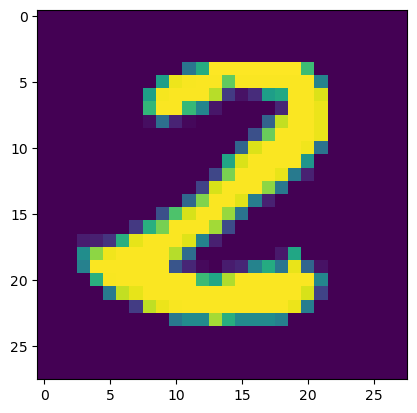

In [61]:
plt.imshow(test_data[4100][0].reshape(28,28))
plt.show()

In [62]:
test_data[4100]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [63]:
# EVAL THE MODEL
with torch.no_grad():
    predicted_val = new_model(test_data[4100][0].view(1,1,28,28))

In [64]:
predicted_val.argmax()

tensor(2)